In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

train_data = pd.read_excel("data/cases_2021_train_processed_2.xlsx")
test_data = pd.read_excel("data/cases_2021_test_processed_unlabelled_2.xlsx")

# 1.1 Feature Selection

In [13]:
train = train_data.copy()
train = train[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio','outcome_group']]
test = test_data.copy()
test = test[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio']]
train_data, test_data = train,test 

# 1.2 Feature Mapping

In [14]:
train = train_data.copy()
train['country'] = pd.factorize(train['country'])[0]
train['chronic_disease_binary'] = pd.factorize(train['chronic_disease_binary'])[0]
new_label = {"outcome_group": {"deceased": 0, "hospitalized": 1, "nonhospitalized": 2}}
train.replace(new_label, inplace = True)
test = test_data.copy()
test['country'] = pd.factorize(test['country'])[0]
test['chronic_disease_binary'] = pd.factorize(test['chronic_disease_binary'])[0]
train_data, test_data = train,test 

# 1.3 Balancing Classes


Before Balancing,
outcome_group
0      997
1    13241
2     2974
dtype: int64


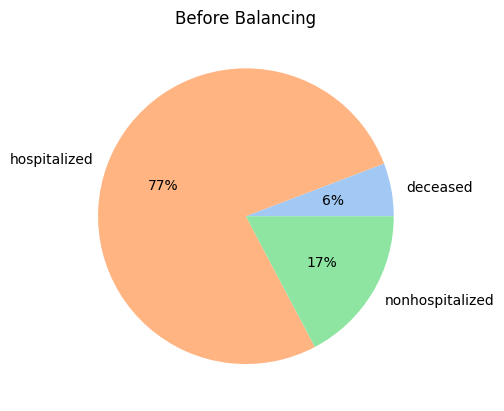


After Balancing,
outcome_group
0     9970
1    10564
2     9814
dtype: int64


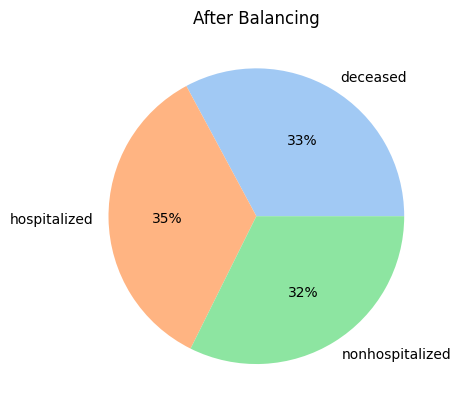

In [15]:
def show_train_dataset_pie_chart(train_dataset: pd.DataFrame, title: str):
    plt.figure()
    data = train_dataset.groupby("outcome_group").size()
    print("\n" + title + ",")
    print(data)
    data = [int(data[0]), int(data[1]), int(data[2])]
    labels = ["deceased", "hospitalized", "nonhospitalized"]
    colours = sns.color_palette('pastel')[0:4]
    plt.pie(x=data, labels=labels, colors=colours, autopct='%.0f%%')
    plt.title(title)
    plt.show()

show_train_dataset_pie_chart(train_data, "Before Balancing")

deceased = train_data[train_data["outcome_group"] == 0]
new_deceased = deceased.sample(frac=10, replace=True, random_state=1)
new_deceased.reset_index(inplace=True, drop=True)

hospitalized = train_data[train_data["outcome_group"] == 1]
hospitalized_sample = np.random.choice(hospitalized.index, 3000, replace=True)
new_hospitalized = hospitalized.drop(hospitalized_sample)
new_hospitalized.reset_index(inplace=True, drop=True)

nonhospitalized = train_data[train_data["outcome_group"] == 2]
new_nonhospitalized = nonhospitalized.sample(frac=3.3, replace=True, random_state=1)
new_nonhospitalized.reset_index(inplace=True, drop=True)

new_train = pd.concat([new_deceased, new_hospitalized, new_nonhospitalized])
new_train.sort_index(axis = 0, inplace=True)
new_train.reset_index(inplace=True, drop=True)

show_train_dataset_pie_chart(new_train, "After Balancing")

train_data = new_train

# 1.4 Building Models

### Train/Validation Split,

In [16]:
train_data, validation_data = train_test_split(train_data, test_size=0.2)

### XG Boost,

In [17]:
# Takes about 4 minutes to run.

# Decide number of k-fold splits
k = 5
# Create model with blank parameters
xgb_model = xgb.XGBClassifier(random_state = 1)
# Create space of possible parameters
parameter_search_space = {
    "learning_rate": [0.2, 0.3],
    "max_depth": [6, 8, 10],
    "n_estimators": [150, 250],
    "objective": ["multi:softmax"],
    "num_class": [3]
}
# Create grid search cross validation object
grid_search_cv = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameter_search_space,
    scoring="f1_macro",
    cv=k,
    verbose=10
)
# Put data and labels in proper format
data = train_data.iloc[:, :4].values
labels = train_data.iloc[:, 4].values.reshape(-1, 1)
# Fit grid search object
grid_search_cv.fit(data, labels)
# Print and save results.
print("XG Boost GridSearchCV best score = " + str(grid_search_cv.best_score_))
print("XG Boost GridSearchCV best parameters = " + str(grid_search_cv.best_params_))
predictions = grid_search_cv.predict(data)
_, _, fscore, _ = precision_recall_fscore_support(predictions, labels)
print("XG Boost GridSearchCV deceased class f1-score = " + str(fscore[0]))
accuracy = accuracy_score(predictions, labels)
print("XG Boost GridSearchCV accuracy score = " + str(accuracy))
pd.DataFrame(grid_search_cv.cv_results_).to_csv("xgboost_results.csv")
xgb_model = grid_search_cv.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 1/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.811 total time=   0.6s
[CV 2/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 2/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.814 total time=   0.6s
[CV 3/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 3/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax;, score=0.801 total time=   0.6s
[CV 4/5; 1/12] START learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objective=multi:softmax
[CV 4/5; 1/12] END learning_rate=0.2, max_depth=6, n_estimators=150, num_class=3, objectiv

### MLP Classifier

In [18]:
# Takes about 12 minutes to run.

from sklearn.neural_network import MLPClassifier
# x_train = train_data[['age', 'country', 'chronic_disease_binary', 'Case_Fatality_Ratio']]
# y_train = train_data[['outcome_group']]
mlp_gs = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

data = train_data.iloc[:, :4].values
labels = train_data.iloc[:, 4].values.reshape(-1, 1)
grid_search_cv = GridSearchCV(
    estimator=mlp_gs,
    param_grid=parameter_space,
    scoring="f1_macro",
    cv=5,
    verbose=10
)
grid_search_cv.fit(data,labels.ravel())

print("MLP Classifier GridSearchCV best score = " + str(grid_search_cv.best_score_))
print("MLP Classifier GridSearchCV best parameters = " + str(grid_search_cv.best_params_))
predictions = grid_search_cv.predict(data)
_, _, fscore, _ = precision_recall_fscore_support(predictions, labels)
print("MLP Classifier GridSearchCV deceased class f1-score = " + str(fscore[0]))
accuracy = accuracy_score(predictions, labels)
print("MLP Classifier GridSearchCV accuracy score = " + str(accuracy))
pd.DataFrame(grid_search_cv.cv_results_).to_csv("MLP Classifier_results.csv")
mlp_gs = grid_search_cv.best_estimator_


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 1/5; 1/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.755 total time=   4.5s
[CV 2/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 2/5; 1/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.352 total time=   1.9s
[CV 3/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 3/5; 1/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.188 total time=   1.5s
[CV 4/5; 1/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 4

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 2/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam;, score=0.774 total time=  10.0s
[CV 1/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.543 total time=   9.4s
[CV 2/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.760 total time=  10.0s
[CV 3/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 3/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.754 total time=   9.9s
[CV 4/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.571 total time=   9.1s
[CV 5/5; 3/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 3/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.763 total time=   9.4s
[CV 1/5; 4/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 4/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.774 total time=  10.1s
[CV 2/5; 4/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 2/5; 4/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.769 total time=   8.4s
[CV 3/5; 4/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 3/5; 4/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.752 total time=   4.8s
[CV 4/5; 4/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 4/5; 4/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.776 total time=   7.2s
[CV 5/5; 4/32] START activati

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 5/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=0.767 total time=   5.2s
[CV 2/5; 5/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd
[CV 2/5; 5/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=0.709 total time=   1.9s
[CV 3/5; 5/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd
[CV 3/5; 5/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=0.728 total time=   4.7s
[CV 4/5; 5/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd
[CV 4/5; 5/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=constant, solver=sgd;, score=0.612 total time=   3.7s
[CV 5/5; 5/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learnin

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.751 total time=   5.1s
[CV 4/5; 7/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.661 total time=   5.3s
[CV 5/5; 7/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 7/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.743 total time=   5.3s
[CV 1/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 8/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.772 total time=   4.5s
[CV 2/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 2/5; 8/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.774 total time=   5.5s
[CV 3/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 3/5; 8/32] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.752 total time=   2.7s
[CV 4/5; 8/32] START activation=tanh, alpha=0.0001, hidden_layer_sizes=(20,), l

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.586 total time=   9.1s
[CV 2/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.683 total time=   9.2s
[CV 3/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.719 total time=   9.1s
[CV 4/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.760 total time=   9.1s
[CV 5/5; 11/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 5/5; 11/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.762 total time=   7.7s
[CV 1/5; 12/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 1/5; 12/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.773 total time=   6.0s
[CV 2/5; 12/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 2/5; 12/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.769 total time=   3.7s
[CV 3/5; 12/32] START activation=tanh, 

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.762 total time=   5.0s
[CV 2/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.768 total time=   5.0s
[CV 3/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 3/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.746 total time=   4.5s
[CV 4/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.770 total time=   5.2s
[CV 5/5; 15/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 5/5; 15/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.765 total time=   4.9s
[CV 1/5; 16/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 16/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.772 total time=   3.3s
[CV 2/5; 16/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 2/5; 16/32] END activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.773 total time=   3.5s
[CV 3/5; 16/32] START activation=tanh, alpha=0.05, hidden_layer_sizes=(20,), learning_ra

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.766 total time=   7.6s
[CV 3/5; 17/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 3/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.756 total time=   2.2s
[CV 4/5; 17/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 4/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.766 total time=   4.1s
[CV 5/5; 17/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd
[CV 5/5; 17/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd;, score=0.666 total time=   5.4s
[CV 1/5; 18/32] START activat

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.768 total time=   7.7s
[CV 2/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 2/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.773 total time=   7.6s
[CV 3/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.751 total time=   7.6s
[CV 4/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.772 total time=   7.7s
[CV 5/5; 19/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd
[CV 5/5; 19/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.763 total time=   7.2s
[CV 1/5; 20/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 1/5; 20/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.769 total time=   3.3s
[CV 2/5; 20/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 2/5; 20/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.777 total time=   3.7s
[CV 3/5; 20/32] START act

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.756 total time=   4.4s
[CV 2/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.763 total time=   4.4s
[CV 3/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.732 total time=   4.5s
[CV 4/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 4/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.769 total time=   4.0s
[CV 5/5; 23/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 5/5; 23/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.766 total time=   4.0s
[CV 1/5; 24/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 24/32] END activation=relu, alpha=0.0001, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.764 total time=   2.4s
[CV 2/5; 24/32] START activation=relu, alpha=0.0001, hidden_layer_sizes=(20,

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.757 total time=   7.6s
[CV 2/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.769 total time=   7.7s
[CV 3/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.757 total time=   7.7s
[CV 4/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.774 total time=   7.8s
[CV 5/5; 27/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 27/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd;, score=0.762 total time=   7.7s
[CV 1/5; 28/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 1/5; 28/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.744 total time=   4.3s
[CV 2/5; 28/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 2/5; 28/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.770 total time=   3.1s
[CV 3/5; 28/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam
[CV 3/5; 28/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=adam;, score=0.755 total time=   4.9s
[CV 4/5; 28/32] START activation=relu

C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.761 total time=   4.5s
[CV 2/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.768 total time=   4.5s
[CV 3/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.760 total time=   4.5s
[CV 4/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd
[CV 4/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.770 total time=   4.4s
[CV 5/5; 31/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd


C:\Users\Gatsby\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 31/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=sgd;, score=0.761 total time=   4.5s
[CV 1/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 1/5; 32/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.756 total time=   4.6s
[CV 2/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 2/5; 32/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.767 total time=   1.5s
[CV 3/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam
[CV 3/5; 32/32] END activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_rate=adaptive, solver=adam;, score=0.758 total time=   2.3s
[CV 4/5; 32/32] START activation=relu, alpha=0.05, hidden_layer_sizes=(20,), learning_

# 1.5 Check for overfitting

### XG Boost,

In [19]:
# Checking for overfitting on XG Boost model by comparing results on train versus validation datasets.
train_data_formatted = train_data.iloc[:, :4].values
train_labels_truth = train_data.iloc[:, 4].values.reshape(-1, 1)
train_labels_predicted = xgb_model.predict(train_data_formatted)
train_data_score = f1_score(train_labels_predicted, train_labels_truth, average = "macro")

validation_data_formatted = validation_data.iloc[:, :4].values
validation_labels_truth = validation_data.iloc[:, 4].values.reshape(-1, 1)
validation_labels_predicted = xgb_model.predict(validation_data_formatted)
validation_data_score = f1_score(validation_labels_predicted, validation_labels_truth, average = "macro")

print("Training Dataset F1-Score = " + str(train_data_score))
print("Validation Dataset F1-Score = " + str(validation_data_score))

Training Dataset F1-Score = 0.820903438284191
Validation Dataset F1-Score = 0.8177177668606479


### MLP Classifier

In [21]:
train_data_formatted = train_data.iloc[:, :4].values
train_labels_truth = train_data.iloc[:, 4].values.reshape(-1, 1)
train_labels_predicted = mlp_gs.predict(train_data_formatted)
train_data_score = f1_score(train_labels_predicted, train_labels_truth, average = "macro")

validation_data_formatted = validation_data.iloc[:, :4].values
validation_labels_truth = validation_data.iloc[:, 4].values.reshape(-1, 1)
validation_labels_predicted = mlp_gs.predict(validation_data_formatted)
validation_data_score = f1_score(validation_labels_predicted, validation_labels_truth, average = "macro")

print("Training Dataset F1-Score = " + str(train_data_score))
print("Validation Dataset F1-Score = " + str(validation_data_score))

Training Dataset F1-Score = 0.7717864021821654
Validation Dataset F1-Score = 0.7789981692891491


# 1.7 Prediction on test sets

In [20]:
import csv
# USING XG BOOST FOR NOW BUT WE CAN SUB THIS OUT FOR BEST PERFORMING MODEL LATER
test_data = test_data.iloc[:, :4].values
predicted_labels = xgb_model.predict(test_data)
# CHANGE MODEL NAME TO BEST PERFORMING MODEL LATER
model_name = "xgboost"
result_data_frame = pd.DataFrame(test_data, columns=["age", "country", "chronic_disease_binary", "Case_Fatality_Ratio"])

# This function is from the TA
def create_submission_file(y_preds, file_name):
    with open(file_name, 'w') as csvfile:
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            wr.writerow([str(i), str(pred)])
create_submission_file(predicted_labels, "submission_"+model_name+".csv")